In [245]:
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import pandas as pd
import bw2analyzer as bwa
from bw2data import Database

In [246]:
bd.projects.set_current("paw_lca")
'paw_db' in bd.databases



True

In [248]:
bd.Database('paw_db').metadata

{'format': 'Excel spreadsheet',
 'depends': ['ecoinvent-3.11-biosphere', 'ecoinvent-3.11-cutoff'],
 'backend': 'sqlite',
 'number': 15,
 'modified': '2025-11-13T16:28:22.454988',
 'geocollections': ['world'],
 'processed': '2025-11-13T16:31:49.032404',
 'dirty': False,
 'searchable': True}

In [249]:
paw_db = bd.Database('paw_db')

In [250]:
ef_gwp_key = [
    m for m in bd.methods if "climate change" == m[2] and "EF v3.1" == m[1]
].pop()
print(ef_gwp_key)

# We can look at the method details
ef_gwp_method = bd.Method(ef_gwp_key)
print(ef_gwp_method)

('ecoinvent-3.11', 'EF v3.1', 'climate change', 'global warming potential (GWP100)')
Brightway2 Method: ecoinvent-3.11: EF v3.1: climate change: global warming potential (GWP100)


### from here multi-lca

In [253]:
for act in paw_db:
    print(act)


'Ozonation' (cubic meter, DE, None)
'transport of fertilizer to soil' (ton kilometer, RER, None)
'Chemicals 102' (cubic meter, RER, None)
'GAC 230' (cubic meter, RER, None)
'Emissions 230' (cubic meter, RER, None)
'BPA to soil' (kilogram, RER, None)
'Electricity 102' (cubic meter, RER, None)
'sludge incineration' (kilogram, Europe without Switzerland, None)
'transport of sludge to incineration' (ton kilometer, RER, None)
'secondary treatment' (cubic meter, Europe without Switzerland, None)
'BPA to water' (kilogram, RER, None)
'Electricity 230' (cubic meter, RER, None)
'Advanced Oxidation Process' (cubic meter, DE, None)
'Activated Carbon Technology' (cubic meter, DE, None)
'Chemicals 230' (cubic meter, RER, None)


In [254]:
list(bd.methods)

[('ecoinvent-3.11',
  'CML v4.8 2016 no LT',
  'acidification no LT',
  'acidification (incl. fate, average Europe total, A&B) no LT'),
 ('ecoinvent-3.11',
  'CML v4.8 2016 no LT',
  'climate change no LT',
  'global warming potential (GWP100) no LT'),
 ('ecoinvent-3.11',
  'CML v4.8 2016 no LT',
  'ecotoxicity: freshwater no LT',
  'freshwater aquatic ecotoxicity (FAETP inf) no LT'),
 ('ecoinvent-3.11',
  'CML v4.8 2016 no LT',
  'ecotoxicity: marine no LT',
  'marine aquatic ecotoxicity (MAETP inf) no LT'),
 ('ecoinvent-3.11',
  'CML v4.8 2016 no LT',
  'ecotoxicity: terrestrial no LT',
  'terrestrial ecotoxicity (TETP inf) no LT'),
 ('ecoinvent-3.11',
  'CML v4.8 2016 no LT',
  'energy resources: non-renewable no LT',
  'abiotic depletion potential (ADP): fossil fuels no LT'),
 ('ecoinvent-3.11',
  'CML v4.8 2016 no LT',
  'eutrophication no LT',
  'eutrophication (fate not incl.) no LT'),
 ('ecoinvent-3.11',
  'CML v4.8 2016 no LT',
  'human toxicity no LT',
  'human toxicity (HTP 

In [256]:
#select the right methods and put it into fitler water tox
water_tox = []
for m in bd.methods:
    if m[1] == 'USEtox v2.13, midpoint' and m[2] == 'ecotoxicity: freshwater':
        water_tox.append(m)


# include gwp100
gwp100 = []
for m in bd.methods:
    if "climate change" == m[2] and "EF v3.1" == m[1] and 'global warming potential (GWP100)':
        gwp100.append(m)


ef_methods = water_tox + gwp100
ef_methods


#'ecotoxicity: freshwater'

[('ecoinvent-3.11',
  'USEtox v2.13, midpoint',
  'ecotoxicity: freshwater',
  'comparative toxic unit for ecosystems (CTUe)'),
 ('ecoinvent-3.11',
  'EF v3.1',
  'climate change',
  'global warming potential (GWP100)')]

In [257]:
for act in paw_db:
    print(act["code"])

dec_tre => sec_tre__nof
102_chem
230_em
wtr_dis => riv
sec_tre => qua_tre__aop
102_elec
qua_tre => inc__nof
sec_tre => qua_tre__o3
230_elec
sldg_trans
fer => soi
230_chem
sldg_sep => fer
230_gac
sec_tre => qua_tre__gac


In [258]:
all_acts_fu = {act["code"]: {act.id: 1.0} for act in paw_db}
print(f"Functional units for {paw_db}: {all_acts_fu}")

config_1 = {"impact_categories": ef_methods}

print(
        f"Testing LCIA with all activities in database '{paw_db}': {len(all_acts_fu)} activities, {len(ef_methods)} methods.")
        

Functional units for Brightway2 SQLiteBackend: paw_db: {'sec_tre => qua_tre__aop': {247382157908238342: 1.0}, '230_elec': {247382157878878208: 1.0}, 'fer => soi': {247382157958569986: 1.0}, '102_chem': {247382157908238340: 1.0}, 'dec_tre => sec_tre__nof': {247382157958569984: 1.0}, '230_em': {247382157908238337: 1.0}, 'qua_tre => inc__nof': {247382157908238343: 1.0}, 'sec_tre => qua_tre__o3': {247382157908238341: 1.0}, '102_elec': {247382157908238339: 1.0}, 'sec_tre => qua_tre__gac': {247382157908238338: 1.0}, 'sldg_sep => fer': {247382157975347200: 1.0}, 'sldg_trans': {247382157958569985: 1.0}, '230_gac': {247382157878878209: 1.0}, '230_chem': {247382157908238336: 1.0}, 'wtr_dis => riv': {247382157975347201: 1.0}}
Testing LCIA with all activities in database 'Brightway2 SQLiteBackend: paw_db': 15 activities, 2 methods.


In [259]:
all_acts_data_objs = bd.get_multilca_data_objs(
            functional_units=all_acts_fu, method_config=config_1
        )
all_acts_mlca = bc.MultiLCA(
    demands=all_acts_fu, method_config=config_1, data_objs=all_acts_data_objs
        )
all_acts_mlca.lci()
all_acts_mlca.lcia()
print("Results for all activities in database generated")

Results for all activities in database generated


In [260]:
dfresults = pd.DataFrame.from_dict(all_acts_mlca.scores, orient='index')
dfresults.index = pd.MultiIndex.from_tuples(dfresults.index, names=['Column', 'Row'])
dfresults = dfresults.unstack(level=0)

dfresults

0  \
Column                  (ecoinvent-3.11, EF v3.1, climate change, global warming potential (GWP100))   
Row                                                                                                    
102_chem                                                          0.053831                             
102_elec                                                          0.080403                             
230_chem                                                          0.319085                             
230_elec                                                          0.109253                             
230_em                                                                 NaN                             
230_gac                                                                NaN                             
dec_tre => sec_tre__nof                                          -0.334391                             
fer => soi                                                        3.010040                             
qua_tre => inc__nof                                              -0.086936                             
sec_tre => qua_tre__aop                                           0.133521                             
sec_tre => qua_tre__gac                                                NaN                             
sec_tre => qua_tre__o3                                            0.134233                             
sldg_sep => fer                                                   0.000000                             
sldg_trans                                                       15.050202                             
wtr_dis => riv                                                    0.000000                             

                                                                                                                                         
Column                  (ecoinvent-3.11, USEtox v2.13, midpoint, ecotoxicity: freshwater, comparative toxic unit for ecosystems (CTUe))  
Row                                                                                                                                      
102_chem                                                        268.080357                                                               
102_elec                                                        340.649922                                                               
230_chem                                                       4723.517643                                                               
230_elec                                                        462.883137                                                               
230_em                                                                 NaN                                                               
230_gac                                                                NaN                                                               
dec_tre => sec_tre__nof                                       -8046.748004                                                               
fer => soi                                                     6389.088077                                                               
qua_tre => inc__nof                                           -2182.062905                                                               
sec_tre => qua_tre__aop                                         957.411399                                                               
sec_tre => qua_tre__gac                                                NaN                                                               
sec_tre => qua_tre__o3                                          608.730279                                                               
sldg_sep => fer                                                 197.482910                                                               
sldg_trans        

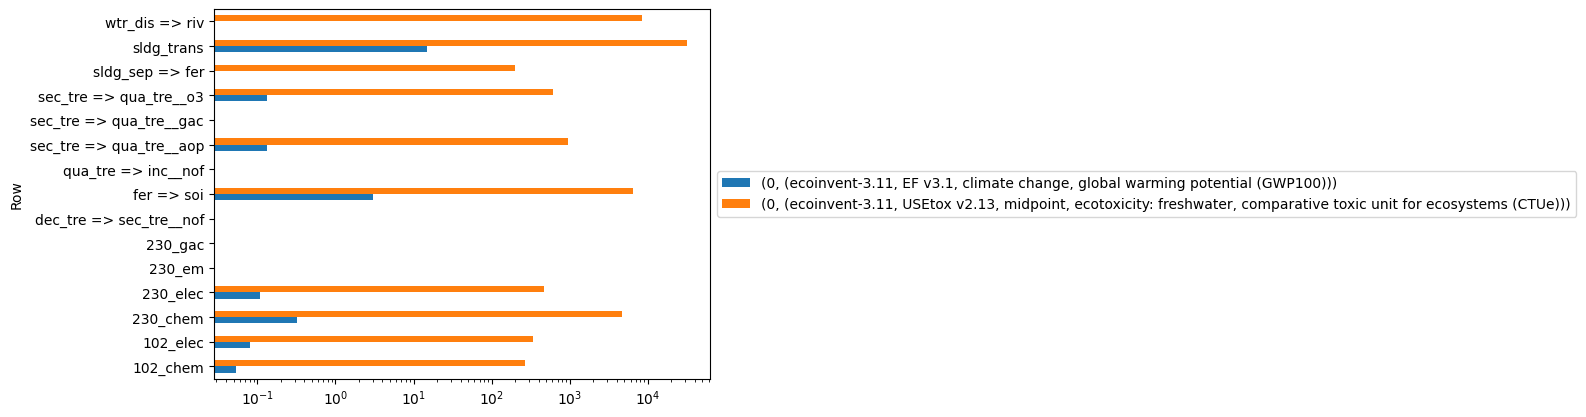

In [261]:

import matplotlib.pyplot as plt

dfresults.plot(kind="barh")
ax = plt.subplot(111)
plt.xscale("log")
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height, box.width, box.height])
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()